# Helicity Angles

**Plan:** Let's look at using the helicity angles for pairing... I want to do this R&D in a nb first to give me a handle on 

1. Which ref frame to use 
2. How to decide which HC / b-jet to use in the angle definitiions.

Also note: I'm trying to keep in mind which of these angles might be best for pairing vs signal vs background discrimination, since I'd like to try to keep this info as orthogonal as possible.


In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr

import sys
sys.path.append("../code")
from preprocess import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 

I'm just going to look at the same file that I was using for JVC (for simplicity).

In [2]:
df = pd.read_hdf("../data/SMNR_Topo-FEB2019/df_f_0.22.h5",key='df')

In [3]:
figDir = "figures"

In [4]:
smText = "$\mathbf{ATLAS}$ Simulation Internal\n"
smText += "SM NR mc16a with 2016 triggers\n"
smText += "4 b-jets $p_T$ > 40 GeV, $|\eta| < 2.5$"

**Step 1: Let's calculate $\cos \theta^*$ in the HH rest frame**

What will I need to do this?
- 4-vectors for the HH system and each of the HCs
- Boost into the HH rest frame
- Calculate $\cos \theta$
- Plot for the correct and incorrect pairs


In [5]:
lab_pair0_hc1 = TLorentzVectorArray.from_ptetaphim(df.pair0_HC1_pt,df.pair0_HC1_eta,
                                                   df.pair0_HC1_phi,df.pair0_HC1_m)

lab_pair0_hc2 = TLorentzVectorArray.from_ptetaphim(df.pair0_HC2_pt,df.pair0_HC2_eta,
                                                   df.pair0_HC2_phi,df.pair0_HC2_m)


lab_pair1_hc1 = TLorentzVectorArray.from_ptetaphim(df.pair1_HC1_pt,df.pair1_HC1_eta,
                                                   df.pair1_HC1_phi,df.pair1_HC1_m)

lab_pair1_hc2 = TLorentzVectorArray.from_ptetaphim(df.pair1_HC2_pt,df.pair1_HC2_eta,
                                                   df.pair1_HC2_phi,df.pair1_HC2_m)

lab_pair2_hc1 = TLorentzVectorArray.from_ptetaphim(df.pair2_HC1_pt,df.pair2_HC1_eta,
                                                   df.pair2_HC1_phi,df.pair2_HC1_m)

lab_pair2_hc2 = TLorentzVectorArray.from_ptetaphim(df.pair2_HC2_pt,df.pair2_HC2_eta,
                                                   df.pair2_HC2_phi,df.pair2_HC2_m)


In [6]:
lab_HH = lab_pair0_hc1 + lab_pair0_hc2

In [7]:
len(lab_HH)

61462

In [8]:
len(df.index)

61462

Boosting into the HH rest frame...

In [9]:
boost = - lab_HH.boostp3

In [10]:
rest_pair0_hc1 = lab_pair0_hc1._to_cartesian().boost(boost)
rest_pair0_hc2 = lab_pair0_hc2._to_cartesian().boost(boost)

rest_pair1_hc1 = lab_pair1_hc1._to_cartesian().boost(boost)
rest_pair1_hc2 = lab_pair1_hc2._to_cartesian().boost(boost)

rest_pair2_hc1 = lab_pair2_hc1._to_cartesian().boost(boost)
rest_pair2_hc2 = lab_pair2_hc2._to_cartesian().boost(boost)

First: Let's take a minute to figure out what the boost into the lab frame is doing to the distributions that we care about.

Ok, so since we're in the rest frame of the hh system, the HCs will be in opposite directions, so the thetas sum to $\pi$

In [11]:
rest_pair0_hc1.theta[0]+rest_pair0_hc2.theta[0]

3.141592653589793

Since cosine is symmetric about $\pi/2$, this means that if I take the absolute value, it doesn't matter which hc I use for $\theta^*$.  For simplicity at this point, I'm just going to calculate it with respect to hc1 (although at this point I don't have any $p_T$ ordering for the HCs.

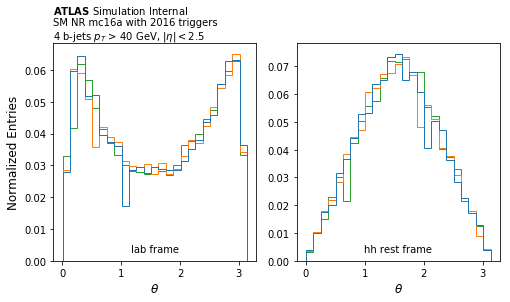

In [12]:
nBins = 25

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.hist([lab_pair0_hc1.theta,lab_pair1_hc1.theta,lab_pair2_hc1.theta],
                 nBins,linestyle='-',histtype='step',
                 weights=[df.mc_sf/np.sum(df.mc_sf)]*3)

ax2.hist([rest_pair0_hc1.theta,rest_pair1_hc1.theta,rest_pair2_hc1.theta],
                nBins,linestyle='-',histtype='step',
                 weights=[df.mc_sf/np.sum(df.mc_sf)]*3)

ax1.set_ylabel('Normalized Entries',fontsize=12)

ax1.set_xlabel(r'$\theta$',fontsize=12)
ax2.set_xlabel(r'$\theta$',fontsize=12)

ax1.text(0,1,smText,ha='left',va='bottom',transform=ax1.transAxes)

for ax,text in zip([ax1,ax2],['lab frame',"hh rest frame"]):
    ax.text(0.5,0.03,text,ha='center',va='bottom',transform=ax.transAxes)

plt.savefig('{}/allPairs_theta.pdf'.format(figDir),bbox_inches='tight')
        
plt.show()

Next: Plot the $\cos \theta$ since this is what Rafael put in the $bb\gamma\gamma$ paper.

In [13]:
nBins = 25

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.hist([np.cos(lab_pair0_hc1.theta),np.cos(lab_pair1_hc1.theta),np.cos(lab_pair2_hc1.theta)],
                 nBins,linestyle='-',histtype='step',
                 weights=[df.mc_sf/np.sum(df.mc_sf)]*3)

ax2.hist([np.cos(rest_pair0_hc1.theta),np.cos(rest_pair1_hc1.theta),np.cos(rest_pair2_hc1.theta)],
                nBins,linestyle='-',histtype='step',
                 weights=[df.mc_sf/np.sum(df.mc_sf)]*3)

ax1.set_ylabel('Normalized Entries',fontsize=12)

ax1.set_xlabel(r'$\cos \theta$',fontsize=12)
ax2.set_xlabel(r'$\cos \theta$',fontsize=12)

for ax,text in zip([ax1,ax2],['lab frame',"hh rest frame"]):
    ax.text(0.5,0.02,text,ha='center',va='bottom',transform=ax.transAxes)

ax1.text(0,1,smText,ha='left',va='bottom',transform=ax1.transAxes)
    
plt.savefig('{}/allPairs_cosTheta.pdf'.format(figDir),bbox_inches='tight')
        
plt.show()

**Plan:** Plot this for the correct and incorrect pairings for the *leading* HC.

In [14]:
badJets = df.badJets.values

In [15]:
N = np.sum(~badJets)

correct_mask = np.zeros((N,3)).astype(bool)
incorrect_mask = np.ones((N,3)).astype(bool)

for i,pidx in enumerate(df.loc[~badJets,'correctPair']):
    correct_mask[i,pidx] = True
    incorrect_mask[i,pidx] = False

In [16]:
cosThetas = np.cos(np.vstack([rest_pair0_hc1.theta, rest_pair1_hc1.theta, rest_pair2_hc1.theta])).T

Recall: This variable is supposed to be *flat* for our signal and peaked to 1 for background (and perhaps the incorrect pairs).

In [42]:
norm = np.sum(df.loc[~badJets,'mc_sf'])

plt.figure(figsize=(4.5,3.5))

plt.hist(np.abs(cosThetas[~badJets][correct_mask]),
         10,(0,1),color='rebeccapurple',#log=True,
         histtype='step',label='correct pair',
         weights=df.loc[~badJets,'mc_sf']/norm)
plt.hist(np.abs(cosThetas[~badJets][incorrect_mask]),
         10,(0,1),color='rebeccapurple',linestyle='--',#
         histtype='step',label='incorrect pairs',
         weights=np.concatenate(np.ones((N,2))*df.loc[~badJets,'mc_sf'].values.reshape(-1,1))/(2*norm))

plt.legend(loc='upper right')
plt.xlabel(r'$|\cos \theta^*|$',fontsize=12)
plt.ylabel('Normalized Entries',fontsize=12)

ax = plt.gca()
ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.07,0.05,'Correct 4 jets',ha='left',va='bottom',transform=ax.transAxes,fontsize=12)

plt.savefig('{}/cosThetaStar.pdf'.format(figDir),bbox_inches='tight')

plt.show()

Ok, the helicity angles do get slightly smeared out for the wrong pairing, but not by a lot.

**Step 2: Let's calculate $\cos \theta*$ with the $\hat{z}$ direction determined by the Collins-Soper frame**

In [18]:
from uproot_methods import TLorentzVector

In [19]:
ebeam = 7000 # GeV

p1 = TLorentzVectorArray([0],[0],[ebeam],[ebeam])
p2 = TLorentzVectorArray([0],[0],[-ebeam],[ebeam])

Boost the beam vectors into the rest frame of the Higgs.

In [20]:
rest_p1 = p1.boost(boost).p3
rest_p2 = p2.boost(boost).p3 

In [21]:
# This is the CS axis that Rafael used, but I think the version that I implemented
# is the one that is actually described in the CS paper.
#CSaxis = rest_p1/rest_p1.mag-rest_p2/rest_p2.mag

CSaxis = rest_p1-rest_p2
CSaxis = CSaxis / CSaxis.mag

In [22]:
cost_p0_hc1 = rest_pair0_hc1.p3.dot(CSaxis) / rest_pair0_hc1.p3.mag 
cost_p0_hc2 = rest_pair0_hc2.p3.dot(CSaxis) / rest_pair0_hc2.p3.mag 

cost_p1_hc1 = rest_pair1_hc1.p3.dot(CSaxis) / rest_pair1_hc1.p3.mag 
cost_p1_hc2 = rest_pair1_hc2.p3.dot(CSaxis) / rest_pair1_hc2.p3.mag 

cost_p2_hc1 = rest_pair2_hc1.p3.dot(CSaxis) / rest_pair2_hc1.p3.mag  
cost_p2_hc2 = rest_pair2_hc2.p3.dot(CSaxis) / rest_pair2_hc2.p3.mag 


In [23]:
cosThetas_CS = np.vstack([cost_p0_hc1, cost_p1_hc1, cost_p2_hc1]).T

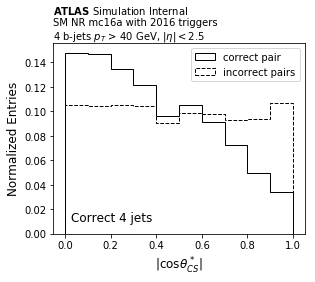

In [46]:
plt.figure(figsize=(4.5,3.5))

plt.hist(np.abs(cosThetas_CS[~badJets][correct_mask]),
         10,(0,1),color='k',#log=True,
         histtype='step',label='correct pair',
         weights=df.loc[~badJets,'mc_sf']/norm)
plt.hist(np.abs(cosThetas_CS[~badJets][incorrect_mask]),
         10,(0,1),color='k',linestyle='--',#
         histtype='step',label='incorrect pairs',
         weights=np.concatenate(np.ones((N,2))*df.loc[~badJets,'mc_sf'].values.reshape(-1,1))/(2*norm))

plt.legend(loc='upper right')
plt.xlabel(r'$|\cos \theta^*_{CS}|$',fontsize=12)
plt.ylabel('Normalized Entries',fontsize=12)

ax = plt.gca()
ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.07,0.05,'Correct 4 jets',ha='left',va='bottom',transform=ax.transAxes,fontsize=12)

plt.savefig('{}/cosThetaStar_CS.pdf'.format(figDir),bbox_inches='tight')

plt.show()

Try overlaying the curves to compare the reference frames.

In [47]:
plt.figure(figsize=(4.5,3.5))

plt.hist(np.abs(cosThetas[~badJets][correct_mask]),
         10,(0,1),color='rebeccapurple',
         histtype='step',label='correct pair',
         weights=df.loc[~badJets,'mc_sf']/norm)
plt.hist(np.abs(cosThetas[~badJets][incorrect_mask]),
         10,(0,1),color='rebeccapurple',linestyle='--',
         histtype='step',label='incorrect pairs',
         weights=np.concatenate(np.ones((N,2))*df.loc[~badJets,'mc_sf'].values.reshape(-1,1))/(2*norm))

plt.hist(np.abs(cosThetas_CS[~badJets][correct_mask]),
         10,(0,1),color='k',
         histtype='step',label='CS: correct pairs',
         weights=df.loc[~badJets,'mc_sf']/norm)
plt.hist(np.abs(cosThetas_CS[~badJets][incorrect_mask]),
         10,(0,1),color='k',linestyle='--',#
         histtype='step',label='CS: incorrect pairs',
         weights=np.concatenate(np.ones((N,2))*df.loc[~badJets,'mc_sf'].values.reshape(-1,1))/(2*norm))

plt.legend(loc='lower left')
plt.xlabel(r'$|\cos \theta^*|$',fontsize=12)
plt.ylabel('Normalized Entries',fontsize=12)

ax = plt.gca()
ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.95,0.9,'Correct 4 jets',ha='right',va='top',transform=ax.transAxes,fontsize=12)

plt.savefig('{}/cosThetaStar_cf_CS.pdf'.format(figDir),bbox_inches='tight')

plt.show()

**Step 3: Let's asses whether this gives us a better handle on the systematic uncertainties by looking at these two definitions versus $p_T^{HH}$ or the jet multiplicity in the event.**

Ok, since the ATLAS analysis didn't use the Collins Soper frame, I'm tempted to not use it either since it makes the math / implementation a little easier, but Rafael said this would be an easy thing to check, so I guess I can!

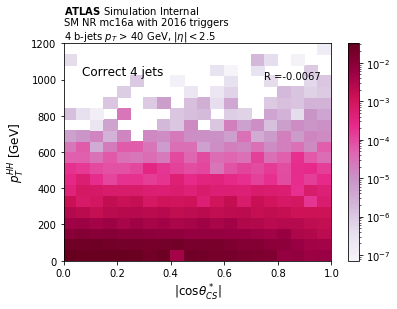

In [26]:
for c,xlabel,tag in zip([cosThetas,cosThetas_CS],
                        [r'$|\cos \theta^*|$',r'$|\cos \theta^*_{CS}|$'],
                        ['','_CS']):
    
    plt.figure()
    plt.hist2d(np.abs(c[~badJets][correct_mask]),lab_HH.pt[~badJets],
               20,[[0,1],[0,1200]],norm=LogNorm(),cmap="PuRd",
               weights=df.loc[~badJets,'mc_sf']/norm)

    R,_ = pearsonr(c[~badJets][correct_mask],lab_HH.pt[~badJets])
    plt.text(.75,1000,"R ={:.4f}".format(R))

    plt.colorbar()
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel('$p_T^{HH}$ [GeV]',fontsize=12)
    
    ax = plt.gca()
    ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
    ax.text(0.07,0.9,'Correct 4 jets',ha='left',va='top',transform=ax.transAxes,fontsize=12)
    
    plt.savefig('{}/pThh_vs_cosThetaStar{}.pdf'.format(figDir,tag),bbox_inches='tight')


    
plt.show()

Hmmmm.... But Rafael also told me that I could look at this binned in terms of jet multiplicity

In [27]:
nJets = df.loc[~badJets,'njets']

Note: This plot is looking at the # of $p_T$ > 40 GeV, $|\eta| < 2.5$ jets that we're using in our analysis, I could look at all of the resolved jets in our analysis as well.

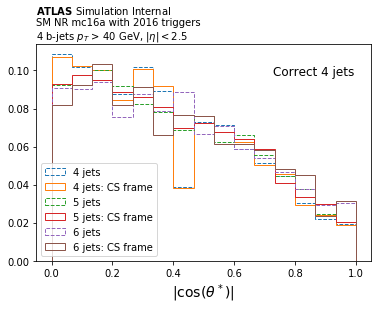

In [28]:
for njets in range(4,7):
    
    mask = (~badJets) & (df.njets==njets)
    n = np.sum(df.loc[mask,'mc_sf'])
    
    plt.hist(np.abs(cosThetas[~badJets][correct_mask][nJets==njets]),
             15,(0,1),histtype='step',label='{} jets'.format(njets),linestyle='--',
             weights=df.loc[mask,'mc_sf']/n)
    
    plt.hist(np.abs(cosThetas_CS[~badJets][correct_mask][nJets==njets]),
             15,(0,1),histtype='step',label='{} jets: CS frame'.format(njets),
             weights=df.loc[mask,'mc_sf']/n)
    
     
ax = plt.gca()
ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
ax.text(0.95,0.9,'Correct 4 jets',ha='right',va='top',transform=ax.transAxes,fontsize=12)

plt.xlabel(r'$|\cos  \left(\theta^* \right)|$',fontsize=14)
plt.legend(loc='lower left')

plt.savefig('{}/cosThetaStar_CS_njets.pdf'.format(figDir),bbox_inches='tight')

plt.show()

Ok, it *really* isn't making a difference.

**Plan:** For future studies, I'm just going to use the std rest frame.

**Mid-play summary**

Ok, this is *awesome*, I investigated a new angle, $\cos \theta^*$, and it's providing some discrimination power between signal and background events. So, I'm going to briefly run through the other angles to see which ones do and don't help. Given this discrimination information, I can *move on* to see how we might want to aggregate it!

**Next:** Let's look at the other two angles that Rafael said were useful for the HH analysis.  In the notation from [the paper](https://arxiv.org/pdf/1208.4018.pdf), the formulas are

$$\cos \theta_1 = - \frac{ \mathbf{q_2} \cdot \mathbf{q_{11}} }{|\mathbf{q_2} || \mathbf{q_{11}}|}, \qquad \cos \theta_2 = - \frac{ \mathbf{q_1} \cdot \mathbf{q_{21}} }{|\mathbf{q_1} || \mathbf{q_{21}}|}$$


Note: For this formula, the three vectors for angle $\theta_i$ are calculated in the rest frame of HC i, so this means the (-) sign is in the formula means that this quantify will be *positive* when the jet is against the direction of motion from the other boson.

The angles are illustrated in the figure below:

<img src="figures/helicityAngles.png" width=400>


So, Rafael explained to me that for the analysis with 4 leptons, you could just choose one charge for the leptons to calculate these charges w/r.t. For calculating these angles on $bb\gamma\gamma$, Rafael just randomly chose one of the photons / jets. 

*I could look at all of them, maybe take the average... idk.*

Plan for implementing this for the pairing check:

I'm going to make columns in the df to test all of these combinations.

In [29]:
lab_j0 = TLorentzVectorArray.from_ptetaphim(df.j0_pt, df.j0_eta, df.j0_phi, df.j0_m)
lab_j1 = TLorentzVectorArray.from_ptetaphim(df.j1_pt, df.j1_eta, df.j1_phi, df.j1_m)
lab_j2 = TLorentzVectorArray.from_ptetaphim(df.j2_pt, df.j2_eta, df.j2_phi, df.j2_m)
lab_j3 = TLorentzVectorArray.from_ptetaphim(df.j3_pt, df.j3_eta, df.j3_phi, df.j3_m)

In [30]:
lab_j2.copy()

<PtEtaPhiMassLorentzVectorArray [TLorentzVector(207.04, 0.48885, -0.095304, 18.612) TLorentzVector(77.097, 0.71759, 1.5658, 8.63) TLorentzVector(157.38, 0.83794, 1.9092, 16.718) ... TLorentzVector(88.928, 1.1393, -3.0139, 8.6785) TLorentzVector(107.57, -0.3156, -2.4693, 10.833) TLorentzVector(77.413, -0.42461, 0.15103, 13.548)] at 0x7f213b0f7908>

In [31]:
'''
Jet pairs for HCs
-----------------------------
    Pair  |  HC 1  |  HC 2
-----------------------------
      1   |  (0,1) |  (2,3)
      2   |  (0,2) |  (1,3)
      3   |  (0,3) |  (1,2)
'''

for pi, (hc1,hc2,j11,j12,j21,j22) in enumerate(zip([lab_pair0_hc1, lab_pair1_hc1, lab_pair2_hc1],
                                               [lab_pair0_hc2, lab_pair1_hc2, lab_pair2_hc2],
                                               [lab_j0]*3,[lab_j1,lab_j2,lab_j3],
                                               [lab_j2,lab_j1,lab_j1],[lab_j3,lab_j3,lab_j2])):
    
    '''
    Calculate theta1 by booosting hc2 and j11 into the rest frame of hc1
    '''
    boost1 = - hc1.boostp3
    
    hc2s = hc2._to_cartesian().boost(boost1).p3
    j11s = j11._to_cartesian().boost(boost1).p3
    df['pair{}_theta1'.format(pi)] = - hc2s.dot(j11s) / (hc2s.mag * j11s.mag)
    
    '''
    Calculate theta2 by booosting hc2 and j11 into the rest frame of hc1
    '''
    boost2 = - hc2.boostp3
    
    hc1s = hc1._to_cartesian().boost(boost2).p3
    j21s = j21._to_cartesian().boost(boost2).p3
    df['pair{}_theta2'.format(pi)] = - hc1s.dot(j21s) / (hc1s.mag * j21s.mag)

    
    '''
    Determine which jet to HC combination is correct, and recalculate 
    the correct theta
    '''
    mask = (j11.pt + j12.pt)  < (j21.pt + j22.pt)
    
    j11s = j21._to_cartesian().boost(boost1).p3
    j21s = j11._to_cartesian().boost(boost2).p3
    
    df.loc[mask,'pair{}_theta1'.format(pi)] = (- hc2s.dot(j11s) / (hc2s.mag * j11s.mag))[mask]
    df.loc[mask,'pair{}_theta2'.format(pi)] = (- hc1s.dot(j21s) / (hc1s.mag * j21s.mag))[mask]
    

Let's start off by just looking at all of them!

In [32]:
col1 = ['pair{}_theta1'.format(pi) for pi in range(3)]
col2 = ['pair{}_theta2'.format(pi) for pi in range(3)]

**Note:** At the HCs are ordered by the scalar sum of the jet $p_T$s.

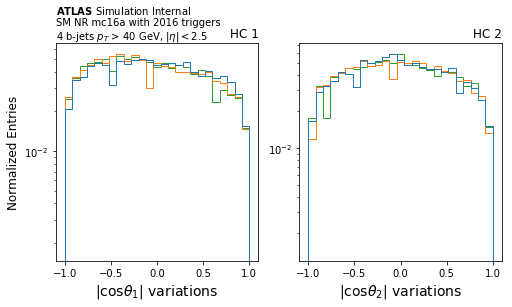

In [33]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.hist(df[col1].values,nBins,(-1,1),log=True,
         histtype='step',
         weights=[df.mc_sf/np.sum(df.mc_sf)]*3)
    
ax2.hist(df[col2].values,nBins,(-1,1),log=True,
         histtype='step',
         weights=[df.mc_sf/np.sum(df.mc_sf)]*3)

ax1.set_title('HC 1',loc='right')
ax2.set_title('HC 2',loc='right')

ax1.set_ylabel('Normalized Entries',fontsize=12)

ax1.set_xlabel(r'$|\cos \theta_1 |$ variations',fontsize=14)
ax2.set_xlabel(r'$|\cos \theta_2 |$ variations',fontsize=14)

ax1.text(0,1,smText,ha='left',va='bottom',transform=ax1.transAxes)

plt.savefig('{}/allPairs_cosTheta1+2.pdf'.format(figDir),bbox_inches='tight')

plt.show()

Ok, these overall distributions look like what I would expect from background, but maybe it's looking this way because this plot is also looking at both of the valid pairings categories?

In [34]:
cosTheta1s = df[col1].values
cosTheta2s = df[col2].values

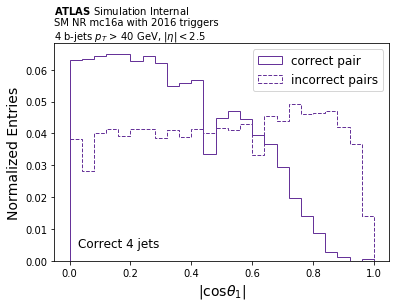

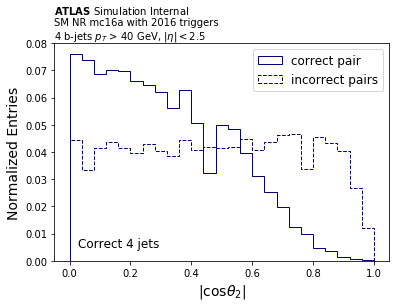

In [45]:
for c,xlabel,color,hci in zip([cosTheta1s,cosTheta2s],
                              [r'$|\cos \theta_1|$',r'$|\cos \theta_2|$'],
                              ['rebeccapurple','navy'],[1,2]):
    
    plt.figure()
    
    plt.hist(np.abs(c[~badJets][correct_mask]),
             nBins,(0,1),color=color,
             histtype='step',label='correct pair',
             weights=df.loc[~badJets,'mc_sf']/norm)
    plt.hist(np.abs(c[~badJets][incorrect_mask]),
             nBins,(0,1),color=color,linestyle='--',
             histtype='step',label='incorrect pairs',
             weights=np.concatenate(np.ones((N,2))*df.loc[~badJets,'mc_sf'].values.reshape(-1,1))/(2*norm))

    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel("Normalized Entries",fontsize=14)
    plt.legend(fontsize=12)
    
    ax = plt.gca()
    ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
    ax.text(0.07,0.05,'Correct 4 jets',ha='left',va='bottom',transform=ax.transAxes,fontsize=12)

    plt.savefig('{}/cosTheta{}.pdf'.format(figDir,hci),bbox_inches='tight')
    
plt.show()

Ok, this looks *better*, in particular the distribution for the incorrect jets looks reasonable. I'm very concerned by this spike at 1 though...

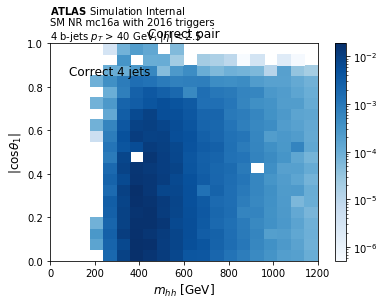

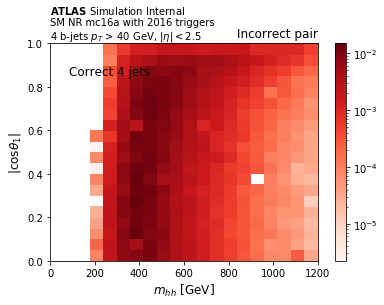

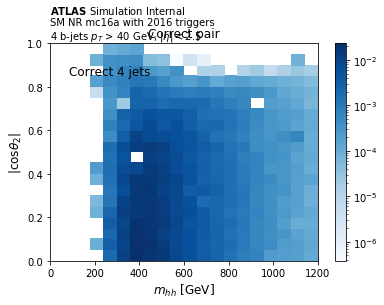

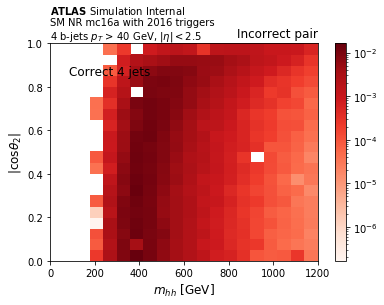

In [36]:
for c,ylabel,hci in zip([cosTheta1s,cosTheta2s],
                        [r'$|\cos \theta_1|$',r'$|\cos \theta_2|$'],[1,2]):
    
    plt.figure()
    plt.hist2d(df.loc[~badJets,'m4j'],np.abs(c[~badJets][correct_mask]),
               20,[[0,1200],[0,1]],norm=LogNorm(),cmap="Blues",
               weights=df.loc[~badJets,'mc_sf']/norm)
    plt.colorbar()
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.title('Correct pair')
    
    ax = plt.gca()
    ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
    ax.text(0.07,0.9,'Correct 4 jets',ha='left',va='top',transform=ax.transAxes,fontsize=12)   

    plt.savefig('{}/cosTheta{}_vs_mhh_correctPair.pdf'.format(figDir,hci),bbox_inches='tight')


    
    plt.figure()
    plt.hist2d(np.concatenate(np.ones((N,2))*df.loc[~badJets,'m4j'].values.reshape(-1,1)),
               np.abs(c[~badJets][incorrect_mask]),
               20,[[0,1200],[0,1]],norm=LogNorm(),cmap="Reds",
               weights=np.concatenate(np.ones((N,2))*df.loc[~badJets,'mc_sf'].values.reshape(-1,1))/(2*norm))

    plt.colorbar()
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.title('Incorrect pair',loc='right')
    
    ax = plt.gca()
    ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
    ax.text(0.07,0.9,'Correct 4 jets',ha='left',va='top',transform=ax.transAxes,fontsize=12)   

    plt.savefig('{}/cosTheta{}_vs_mhh_incorrectPair.pdf'.format(figDir,hci),bbox_inches='tight')


    
plt.show()

Probably the more useful metric here would be the average of $|\cos\theta_{1,2}|$ in different $m_{hh}$ bins...

I should also look at the correlation with $m_1$ and $m_2$, and maybe it would also be interesting to see $m_1$ and $m_2$ as a function of $m_{hh}$ for correct and incorrect pairs? Or the $p_T$ of the HCs / whatever quantities we're trying to cut on?

**Last two angles**

I don't understand the math, but they're "the azimuthal angles between the three planes constructed from the X decay products and the two $V_i$ in the X rest frame."

$$\Phi = \frac{q_1 \cdot \left(  \hat{n}_1 \times \hat{n}_2  \right) }{|q_1 \cdot \left(  \hat{n}_1 \times \hat{n}_2  \right) |} \times \cos^{-1}\left( - \hat{n}_1 \cdot \hat{n}_2  \right)$$

$$\Phi_1 = \frac{q_1 \cdot \left(  \hat{n}_1 \times \hat{n}_{sc}  \right) }{|q_1 \cdot \left(  \hat{n}_1 \times \hat{n}_{sc}  \right) |} \times \cos^{-1}\left( \hat{n}_1 \cdot \hat{n}_{sc}  \right)$$


Where the normal vectors are giving by the following equations:

$$\hat{n}_1 = \frac{q_{11}\times q_{12}}{|q_{11}\times q_{12}|}, \qquad \hat{n}_2 = \frac{q_{21}\times q_{22}}{|q_{21}\times q_{22}|}, \qquad  \hat{n}_{sc} = \frac{\hat{n}_z \times q_1}{|\hat{n}_z \times q_1|}$$

*I'm so sad, I can't follow this geometry...* ;(

But that's ok, I think I can code this up (at least).

In [37]:
from uproot_methods.classes.TVector3 import TVector3Array

In [38]:
for pi, (hc1,j11,j12,j21,j22) in enumerate(zip([rest_pair0_hc1, rest_pair1_hc1, rest_pair2_hc1],
                                               #[lab_pair0_hc2, lab_pair1_hc2, lab_pair2_hc2],
                                               [lab_j0]*3,[lab_j1,lab_j2,lab_j3],
                                               [lab_j2,lab_j1,lab_j1],[lab_j3,lab_j3,lab_j2])):


    '''
    Step 1: Get the jets in the hh rest frame
    '''
    rest_j11 = j11._to_cartesian().boost(boost) 
    rest_j12 = j12._to_cartesian().boost(boost)

    rest_j21 = j21._to_cartesian().boost(boost)
    rest_j22 = j22._to_cartesian().boost(boost)

    rest_j11 = TVector3Array(rest_j11.x, rest_j11.y, rest_j11.z)
    rest_j12 = TVector3Array(rest_j12.x, rest_j12.y, rest_j12.z)

    rest_j21 = TVector3Array(rest_j21.x, rest_j21.y, rest_j21.z)
    rest_j22 = TVector3Array(rest_j22.x, rest_j22.y, rest_j22.z)

    z = TVector3Array(rest_p1.x, rest_p1.y, rest_p1.z)
    rest_hc1 = TVector3Array(hc1.x, hc1.y, hc1.z)
    
    '''
    Step 2: Get the normal vectors for the 3 planes
    '''
    n1  = rest_j11.cross(rest_j12) / rest_j11.cross(rest_j12).mag 
    n2  = rest_j21.cross(rest_j22) / rest_j21.cross(rest_j22).mag 
    nsc = z.cross(rest_hc1) / z.cross(rest_hc1).mag 

    '''
    Step 3: Get the angles
    '''
    Phi  = np.arccos(- n1.dot(n2))
    Phi *= rest_hc1.dot(n1.cross(n2)) / np.abs(rest_hc1.dot(n1.cross(n2)))

    df['pair{}_Phi'.format(pi)] = Phi
    
    Phi1  =  np.arccos(n1.dot(nsc))
    Phi1 *=  rest_hc1.dot(n1.cross(nsc)) / np.abs(rest_hc1.dot(n1.cross(nsc)))

    df['pair{}_Phi1'.format(pi)] = Phi1
    
    '''
    Take into account the HC ordering
    '''
    mask = (j11.pt + j12.pt)  < (j21.pt + j22.pt)
    Phi1  =  np.arccos(n2.dot(nsc))
    Phi1 *=  rest_hc1.dot(n2.cross(nsc)) / np.abs(rest_hc1.dot(n2.cross(nsc)))
    df.loc[mask,'pair{}_Phi1'.format(pi)] = Phi1[mask]
    

In [39]:
Phis  = df[['pair{}_Phi'.format(pi) for pi in range(3)]].values
Phi1s = df[['pair{}_Phi1'.format(pi) for pi in range(3)]].values

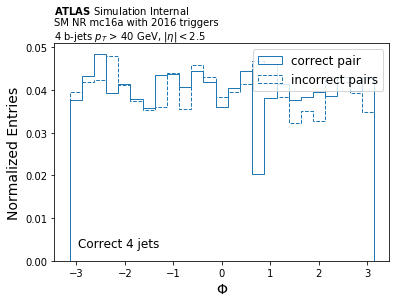

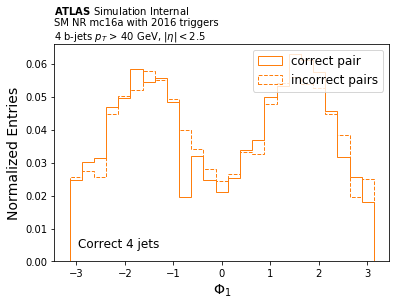

In [41]:
for c,xlabel,color,tag in zip([Phis,Phi1s],[r'$\Phi$',r'$\Phi_1$'],['C0','C1'],['','1']):
    
    plt.figure()
    
    plt.hist(c[~badJets][correct_mask],
             nBins,(-np.pi,np.pi),color=color,
             histtype='step',label='correct pair',
             weights=df.loc[~badJets,'mc_sf']/norm)
    plt.hist(c[~badJets][incorrect_mask],
             nBins,(-np.pi,np.pi),color=color,linestyle='--',
             histtype='step',label='incorrect pairs',
             weights=np.concatenate(np.ones((N,2))*df.loc[~badJets,'mc_sf'].values.reshape(-1,1))/(2*norm))

    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel("Normalized Entries",fontsize=14)
    plt.legend(fontsize=12)

    ax = plt.gca()
    ax.text(0,1,smText,ha='left',va='bottom',transform=ax.transAxes)
    ax.text(0.07,0.05,'Correct 4 jets',ha='left',va='bottom',transform=ax.transAxes,fontsize=12)
    
    plt.savefig('{}/Phi{}.pdf'.format(figDir,tag),bbox_inches='tight')


    
plt.show()

**Conclusion:** These variables don't provide any discrimination for determining the correct pa

**Suggestion from Max and Rafael:** Also look at the properties of the background for these helicity angles.

(I can't look at correct / incorrect pairings for this, but *maybe* it would be usefulto see what these helicity angles look like for the MDR+$D_{hh}$ and min $\Delta R_{jj}$ pairings.

I also wanted to compare cutflows for the MDR+$D_{hh}$ and min $\Delta R_{jj}$ pairings, but I think I should do this in another notebook.


**Follow-up** I think it would be really nice to do a LO calculation for this spin structure of the paricles, but I'm not 100% sure if this is something that I'm capable of or not... but maybe worth a shot, especially if this is something that is easy.